<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/notebooks/pipelines/xgboost-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import sys

!{sys.executable} -m pip install -U xgboost==1.6.0 -q
!{sys.executable} -m pip install shap==0.41.0 -q

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import joblib

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
drive.mount('/content/drive')

In [4]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df_train.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1


In [5]:
df_test.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
356588,She was born with the name Maria SkÅ odowska i...,she be bear with the name maria sk odowska in ...,7.174366,4.007143,3.57,5.11,2.86,1.43,4.88,12.0,0
304697,The highest wind gust reported in Guadeloupe w...,the high wind gust report in guadeloupe be 84 ...,6.333686,5.620000,3.69,8.66,2.94,1.43,3.93,14.0,0


In [142]:
num_features = ['d_chall_score', 'aoa_max', 'num_lemmas']

text_features = 'lemmatized_text'

def build_preprocessing_pipe(tfidf_kwargs={}):

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  preprocessor = ColumnTransformer([
      ('num', 'passthrough', num_features),
      ('text', text_pipe, text_features),
  ])

  pipe = Pipeline([
      ('preprocessor', preprocessor),
  ])

  return pipe

def build_clf(tfidf_kwargs={}, clf_kwargs={}):

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  preprocessor = ColumnTransformer([
      ('num', 'passthrough', num_features),
      ('text', text_pipe, text_features),
  ])

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', xgb.XGBRFClassifier(**clf_kwargs))
  ])

  return clf

In [ ]:
base_params = {
              'objective': 'binary:logistic', 
              'tree_method':'gpu_hist',
              'eval_metric':'error',
              'gpu_id':0,
              'n_jobs':-1,
              'seed':99,
               }
param_grid = ParameterGrid({
              'max_depth':[16],
              'colsample_bytree':[.5],
              'sampling_method':['gradient_based'],
              'subsample':[.2, .4],
              'alpha':[.8, 10],
              'eta':[1e-3]
              })

tfidf_params = {'min_df':50, 'ngram_range':(1, 3), 'max_features':500}

def get_best_params_cv(df, base_params, param_grid, tfidf_params, n_splits=10):
  pipe = build_preprocessing_pipe(tfidf_params)
  skf = StratifiedKFold(n_splits=n_splits)

  best_test_scores = np.zeros(len(param_grid))
  best_train_scores = np.zeros(len(param_grid))
  best_boost_rounds = np.zeros(len(param_grid))

  for i, params in enumerate(param_grid):
    print('params', params)
    test_scores = np.zeros(n_splits)
    train_scores = np.zeros(n_splits)
    boost_rounds = np.zeros(n_splits)

    for n, (train_index, test_index) in enumerate(skf.split(df, df.label)):
      X_train = pipe.fit_transform(df.iloc[train_index])
      X_test = pipe.transform(df.iloc[test_index])
      y_train = df.label.iloc[train_index]
      y_test = df.label.iloc[test_index]

      dtrain = xgb.DMatrix(X_train, y_train)
      dtest = xgb.DMatrix(X_test, y_test)

      evals = [(dtest, 'test'), (dtrain, 'train')]
      evals_result = {}

      bst =  xgb.train(
          params={**params, **base_params},
          dtrain=dtrain, 
          evals=evals,
          num_boost_round=500,
          early_stopping_rounds=50,
          evals_result=evals_result,
          verbose_eval=None,
          )
      
      ix = np.argmin(evals_result['test']['error'])
      test_scores[n] = evals_result['test']['error'][ix]
      train_scores[n] = evals_result['train']['error'][ix]
      boost_rounds[n] = ix + 1
      print('fold', n+1)
      print('\ttest_accuracy', np.round(1-test_scores[n], 4), 
            'train_accuracy', np.round(1-train_scores[n], 4), 
            'best_boost_round', boost_rounds[n])

    best_test_scores[i] = test_scores.mean()
    best_train_scores[i] = train_scores.mean()
    best_boost_rounds[i] = np.int64(boost_rounds.mean())

  best_ix = np.argmin(best_test_scores)

  ret_val =dict(
    best_params=param_grid[best_ix],
    best_test_score=1-best_test_scores[best_ix],
    best_train_score=1-best_train_scores[best_ix],
    best_boost_rounds=best_boost_rounds[best_ix],
  )

  print('Finished!')
  for key, val in ret_val.items():
    print(f'{key}:', val)

  return ret_val


xgb_cv_results = get_best_params_cv(df_train.sample(40000, random_state=99, replace=False), 
                base_params, 
                param_grid, 
                tfidf_params,
                n_splits=5)

params {'alpha': 0.8, 'colsample_bytree': 0.5, 'eta': 0.001, 'max_depth': 16, 'sampling_method': 'gradient_based', 'subsample': 0.2}
fold 1
	test_accuracy 0.6702 train_accuracy 0.7163 best_boost_round 36.0
fold 2
	test_accuracy 0.6724 train_accuracy 0.7409 best_boost_round 422.0


Build classifier using best params

In [118]:
clf = build_clf(tfidf_params, 
                {**base_params, **xgb_cv_results['best_params']})

Final test on our training data to see if our model is overfitting.

In [119]:
X_train, X_val, y_train, y_val = train_test_split(df_train[num_features + [text_features]], 
                                                  df_train['label'],
                                                  test_size=.25,
                                                  stratify=df_train['label'], 
                                                  random_state=99)

clf = clf.fit(X_train, y_train)

train_y_proba = clf.predict_proba(X_train)[:, 1]
train_y_hat = clf.predict(X_train)

val_y_proba = clf.predict_proba(X_val)[:, 1]
val_y_hat = clf.predict(X_val)

train_roc_auc = metrics.roc_auc_score(y_train, train_y_proba)
train_accuracy = metrics.accuracy_score(y_train, train_y_hat)
train_f1 = metrics.f1_score(y_train, train_y_hat)
train_precision = metrics.precision_score(y_train, train_y_hat)
train_recall = metrics.recall_score(y_train, train_y_hat)

val_roc_auc = metrics.roc_auc_score(y_val, val_y_proba)
val_accuracy = metrics.accuracy_score(y_val, val_y_hat)
val_f1 = metrics.f1_score(y_val, val_y_hat)
val_precision = metrics.precision_score(y_val, val_y_hat)
val_recall = metrics.recall_score(y_val, val_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Validation ROC AUC:', val_roc_auc)
print('Validation Accuracy Score:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Precision Score:', val_precision)
print('Validation Recall Score:', val_recall)


Train ROC AUC: 0.7545856958116776
Train Accuracy Score: 0.678869895030197
Train F1 Score: 0.6755471595112735
Train Precision Score: 0.6826076542869378
Train Recall Score: 0.668631228716257

Validation ROC AUC: 0.732592556463375
Validation Accuracy Score: 0.6623974918153414
Validation F1 Score: 0.6589973933087745
Validation Precision Score: 0.6657091249374334
Validation Recall Score: 0.652419647236974


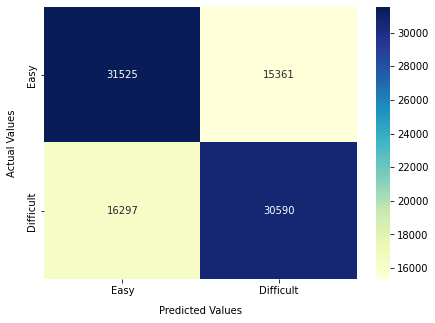

In [120]:
def plot_cf_matrix(y_true, y_pred):
  cf_matrix = metrics.confusion_matrix(y_true, y_pred).round(0)
  tick_lables = ('Easy', 'Difficult')

  fig = plt.figure(figsize=(7, 5))
  ax = plt.gca()
  ax = sns.heatmap(cf_matrix, 
              annot=True,
              fmt='.0f',
              xticklabels=tick_lables,
              yticklabels=tick_lables,
              cmap=mpl.cm.get_cmap('YlGnBu'),
              ax=ax,)
  
  ax.set_xlabel('Predicted Values', labelpad=10.0)
  ax.set_ylabel('Actual Values', labelpad=10.0)

plot_cf_matrix(y_val, val_y_hat)

Lets look at the most important features

In [121]:
text_features_trf = list(clf['preprocessor']
                         .transformers_[1][1]
                         .get_feature_names_out())

all_features = num_features + text_features_trf

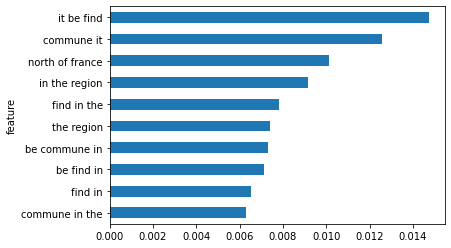

In [122]:
feature_importances = pd.DataFrame({'feature':all_features, 'importance':clf[-1].feature_importances_})

# What are top 10 most important features
def plot_top_10(df_plot):
  df_plot = (df_plot
    .sort_values('importance', ascending=False)
    .head(10)
    .sort_values('importance'))
  df_plot.plot.barh('feature', 'importance',
                    legend=None)

plot_top_10(feature_importances)

## Final Test

In [37]:
clf.fit(df_train, df_train['label'])

train_y_proba = clf.predict_proba(df_train)[:, 1]
train_y_hat = clf.predict(df_train)

test_y_proba = clf.predict_proba(df_test)[:, 1]
test_y_hat = clf.predict(df_test)

train_roc_auc = metrics.roc_auc_score(df_train['label'], train_y_proba)
train_accuracy = metrics.accuracy_score(df_train['label'], train_y_hat)
train_f1 = metrics.f1_score(df_train['label'], train_y_hat)
train_precision = metrics.precision_score(df_train['label'], train_y_hat)
train_recall = metrics.recall_score(df_train['label'], train_y_hat)

test_roc_auc = metrics.roc_auc_score(df_test['label'], test_y_proba)
test_accuracy = metrics.accuracy_score(df_test['label'], test_y_hat)
test_f1 = metrics.f1_score(df_test['label'], test_y_hat)
test_precision = metrics.precision_score(df_test['label'], test_y_hat)
test_recall = metrics.recall_score(df_test['label'], test_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Test ROC AUC:', test_roc_auc)
print('Test Accuracy Score:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test Precision Score:', test_precision)
print('Test Recall Score:', test_recall)


Train ROC AUC: 0.7350092485030044
Train Accuracy Score: 0.6637864843824982
Train F1 Score: 0.6561512475358746
Train Precision Score: 0.6713983606465904
Train Recall Score: 0.6415812653962228

Test ROC AUC: 0.7295706734913379
Test Accuracy Score: 0.6613158652461849
Test F1 Score: 0.6533218715461132
Test Precision Score: 0.6691150576042663
Test Recall Score: 0.6382570304251848
